In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


## 1. Exploratory Analysis

### 1-1. load the train set

In [2]:
train = pd.read_csv('bankruptcytrainpost.csv')
train.shape

(44, 13)

### 1-2. checking balancing of the target variable

In [3]:
train['FAIL'].value_counts()

1    22
0    22
Name: FAIL, dtype: int64

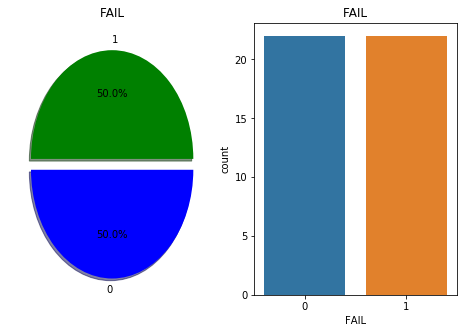

In [4]:
f, ax = plt.subplots(1,2, figsize = (8,5))
train['FAIL'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%'
                                            ,ax=ax[0],shadow=True, colors =['green','blue'])
ax[0].set_title('FAIL')
ax[0].set_ylabel('')
sns.countplot('FAIL', data = train, ax = ax[1])
ax[1].set_title('FAIL')
plt.show()

Since two classes of '0' and '1' are balanced, it is good to start modeling.

In [5]:
y_train = pd.DataFrame(train['FAIL'])
x_train = train.drop(y_train, axis = 1)
x_train.head()

,SALES,ROCE,FFTL,GEAR,CLTA,CACL,QACL,WCTA,LAG,AGE,CHAUD,BIG6
0,7646,31.2239,0.6312,0.5205,0.4829,1.6397,1.4935,0.3089,286,25,0,0
1,36067,10.9613,0.3540,0.3786,0.3786,1.5852,1.1626,0.2216,301,33,0,1
2,16737,17.9949,0.4388,0.5236,0.4347,1.1748,0.9795,0.0760,55,26,0,1
3,48162,6.1787,0.1181,0.9996,0.7437,1.3007,0.9070,0.2236,303,34,0,0
4,6953,0.0648,0.1447,0.9520,0.4976,1.0410,0.5355,0.0204,362,14,1,1


### 1-3. Feature Selection by RFE

In [6]:
from sklearn.feature_selection import RFE
lg = LogisticRegression()
rfe = RFE(lg, 12)
rfe = rfe.fit(x_train, y_train)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1]


RFE suggests that all columns are worthy

### 1-4. Histogram of the features

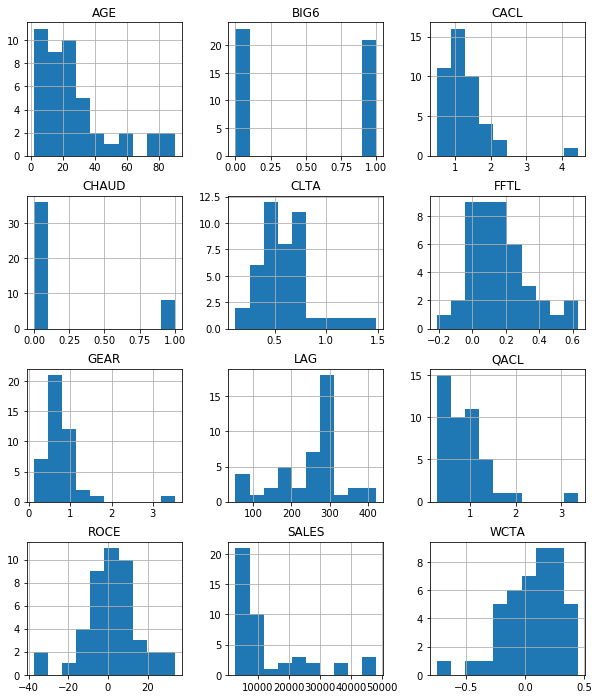

In [7]:
x_train.hist(figsize=[10,12])
plt.show()

Scales are too different and few feature are not normalized at all.

Since the histogram shows that BIG6 and CHAUD are categorical variables, I will explore only continuous variables and their corrleations

### 1-5. Scale the continuous variables

In [8]:
#cont = ['AGE','CACL','CLTA','FFTL','GEAR','LAG','QACL','ROCE','SALES','WCTA']
#x_train = preprocessing.scale(x_train)
#x_train[cont] = preprocessing.normalize(x_train[cont])
#x_train = pd.DataFrame(x_train[cont])
#x_train.hist(figsize = [10,12])
#plt.show()

### 1-6. Correlation for continuous variables

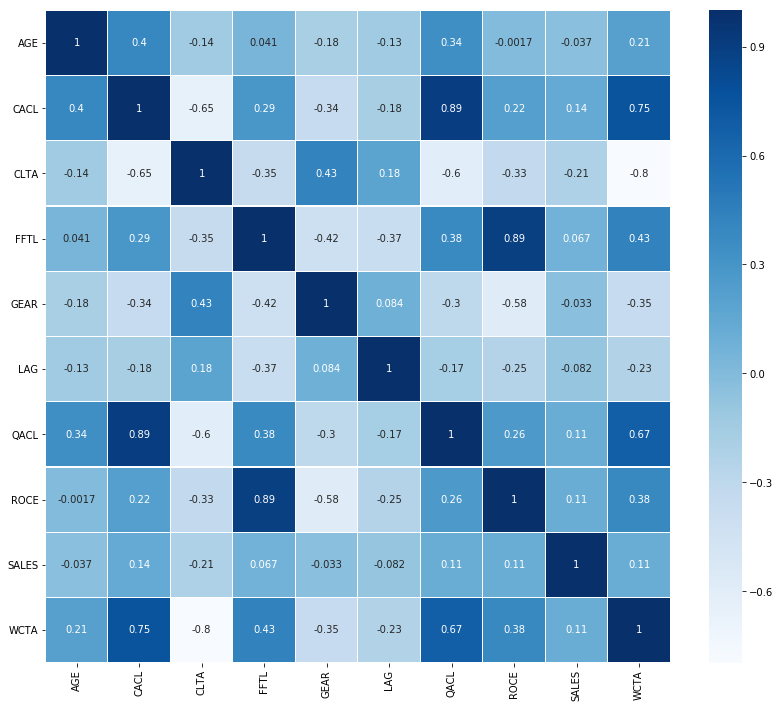

In [9]:
cont = ['AGE','CACL','CLTA','FFTL','GEAR','LAG','QACL','ROCE','SALES','WCTA']
a = pd.DataFrame(x_train[cont].corr())
sns.heatmap(a, annot = True, linewidths = 0.2, cmap = "Blues")
fig = plt.gcf()
fig.set_size_inches(14,12)
plt.show()

### 1-6. Drop one of the variables which generates higher correlation to avoid multicollinearity

WCTA, FFTL, QACL

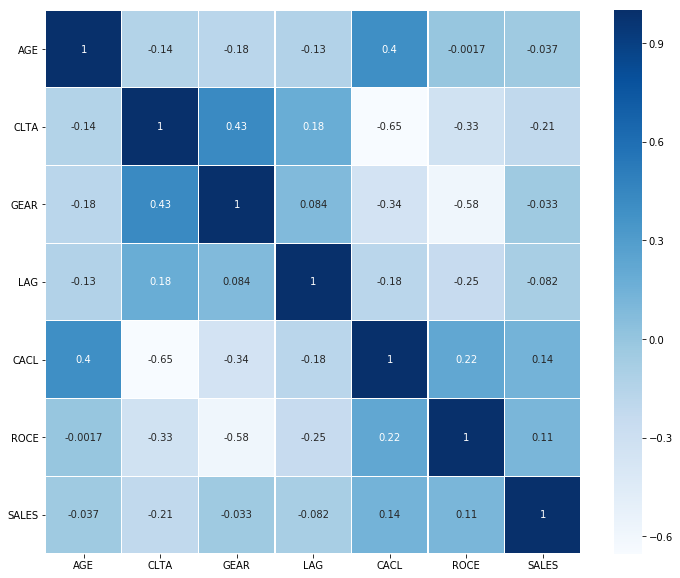

In [10]:
FS = ['AGE','CLTA','GEAR','LAG','CACL','ROCE','SALES']
a = pd.DataFrame(x_train[FS].corr())
sns.heatmap(a, annot = True, linewidths = 0.2, cmap = "Blues")
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.show()

The variables are now independent to each other

In [11]:
FS = ['AGE','CLTA','GEAR','LAG','CACL','ROCE','SALES','CHAUD','BIG6']
x_train = pd.DataFrame(x_train[FS])

## 2. Modeling Logistic Regression and Evaluating

In [12]:
import statsmodels.api as sm
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
#result.params
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     9.556
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           3.58e-07
Time:                        21:24:59   Log-Likelihood:                -19.894
No. Observations:                  44   AIC:                             57.79
Df Residuals:                      35   BIC:                             73.85
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0058      0.003     -1.711      0.0

#### Remove 'CACL'

In [13]:
FS = ['AGE','CLTA','GEAR','LAG','ROCE','SALES','CHAUD','BIG6']
x_train = pd.DataFrame(x_train[FS])
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     11.00
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           1.09e-07
Time:                        21:24:59   Log-Likelihood:                -19.975
No. Observations:                  44   AIC:                             55.95
Df Residuals:                      36   BIC:                             70.22
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0051      0.003     -1.914      0.0

#### Remove 'GEAR'

In [14]:
FS = ['AGE','CLTA','LAG','ROCE','SALES','CHAUD','BIG6']
x_train = pd.DataFrame(x_train[FS])
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     12.74
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           3.41e-08
Time:                        21:24:59   Log-Likelihood:                -20.190
No. Observations:                  44   AIC:                             54.38
Df Residuals:                      37   BIC:                             66.87
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0052      0.003     -1.982      0.0

#### Remove  'ROCE'

In [15]:
FS = ['AGE','CLTA','LAG','SALES','CHAUD','BIG6']
x_train = pd.DataFrame(x_train[FS])
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     15.17
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           8.94e-09
Time:                        21:24:59   Log-Likelihood:                -20.294
No. Observations:                  44   AIC:                             52.59
Df Residuals:                      38   BIC:                             63.29
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0053      0.003     -2.080      0.0

#### Remove  'SALES'

In [16]:
FS = ['AGE','CLTA','LAG','CHAUD','BIG6']
x_train = pd.DataFrame(x_train[FS])
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     18.23
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           2.68e-09
Time:                        21:24:59   Log-Likelihood:                -20.672
No. Observations:                  44   AIC:                             51.34
Df Residuals:                      39   BIC:                             60.27
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0050      0.003     -1.992      0.0

#### Remove 'CHAUD'

In [17]:
FS = ['AGE','CLTA','LAG','BIG6']
x_train = pd.DataFrame(x_train[FS])
logit_model=sm.OLS(y_train,x_train)
result=logit_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   FAIL   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     21.23
Date:                Sun, 01 Apr 2018   Prob (F-statistic):           1.87e-09
Time:                        21:24:59   Log-Likelihood:                -22.130
No. Observations:                  44   AIC:                             52.26
Df Residuals:                      40   BIC:                             59.40
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGE           -0.0057      0.003     -2.239      0.0

### y test

In [18]:
x_test = pd.read_csv('bankruptcytestpostnolabel.csv')
#x_test[cont] = preprocessing.scale(x_test[cont])
x_test = pd.DataFrame(x_test[FS])
x_test.head()

,AGE,CLTA,LAG,BIG6
0,5,0.7444,243,1
1,14,0.7320,301,0
2,13,0.1538,117,1
3,6,1.1831,183,1
4,51,0.3426,191,0


## 3. Supervised Modeling

In [19]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
kfold = KFold(n_splits = 5)
cv_result = cross_val_score(clf, x_train, y_train, scoring = 'accuracy', cv = kfold)
print(cv_result.mean())

0.6749999999999999


## 4. Hyper Parameter

In [21]:
param_grid = {"penalty" : ['l1', 'l2'], "C" : np.logspace(-5, 5, 10)}
lrc = GridSearchCV(estimator = clf, param_grid = param_grid, cv = kfold)
lrc.fit(x_train,y_train)
print("Train Accuracy for the tuned model", lrc.best_score_)
bestModel = lrc.best_estimator_
bestModel

Train Accuracy for the tuned model 0.7045454545454546


LogisticRegression(C=0.2782559402207126, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## 5. Prediction

### Create y_test set using the best tuned model

In [27]:
y_index = pd.DataFrame(np.arange(1,17))
y_value = pd.Series(bestModel.predict(x_test), name = 'FAIL')
y_test = pd.concat([y_index, y_value], axis = 1)
y_test

,0,FAIL
0,1,1
1,2,1
2,3,0
3,4,1
4,5,0
5,6,0
6,7,1
7,8,0
8,9,1
9,10,1


## 6. Save y_test as a csv file

In [28]:
y_test.to_csv("y_test.csv", index = False)